# Deep Learning for Malaria Diagnosis
This notebook is inspired by works of (Sivaramakrishnan Rajaraman  et al., 2018) and (Jason Brownlee, 2019). Acknowledge to NIH and Bangalor Hospital who make available this malaria dataset.

Malaria is an infectuous disease caused by parasites that are transmitted to people through the bites of infected female Anopheles mosquitoes.

The Malaria burden with some key figures:
<font color='red'>
* More than 219 million cases
* Over 430 000 deaths in 2017 (Mostly: children & pregnants)
* 80% in 15 countries of Africa & India
  </font>

![MalariaBurd](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/MalariaBurden.png?raw=1)

The malaria diagnosis is performed using blood test:
* Collect patient blood smear
* Microscopic visualisation of the parasit

![MalariaDiag](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/MalariaDiag.png?raw=1)
  
Main issues related to traditional diagnosis:
<font color='#ed7d31'>
* resource-constrained regions
* time needed and delays
* diagnosis accuracy and cost
</font>

The objective of this notebook is to apply modern deep learning techniques to perform medical image analysis for malaria diagnosis.

*This notebook is inspired by works of (Sivaramakrishnan Rajaraman  et al., 2018), (Adrian Rosebrock, 2018) and (Jason Brownlee, 2019)*

## Configuration

In [1]:
#Mount the local drive project_forder
from google.colab import drive
drive.mount('/content/drive/')
!ls "/content/drive/My Drive/Colab Notebooks/10xDS/Projects/malaria-diagnosis/"

Mounted at /content/drive/
ls: cannot access '/content/drive/My Drive/Colab Notebooks/10xDS/Projects/malaria-diagnosis/': No such file or directory


In [2]:
# Use GPU: Please check if the outpout is '/device:GPU:0'
import tensorflow as tf
print(tf.__version__)
tf.test.gpu_device_name()
#from tensorflow.python.client import device_lib
#device_lib.list_local_devices()

2.19.0


''

## Populating namespaces

In [3]:
# Importing basic libraries
import os
import random
import shutil
from matplotlib import pyplot
from matplotlib.image import imread
%matplotlib inline

# Importing the Keras libraries and packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D as Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [4]:
# Set image dimensions (adjust based on your dataset)
IMG_HEIGHT, IMG_WIDTH = 128, 128
BATCH_SIZE = 32
EPOCHS = 10

# Define the useful paths for data accessibility
ai_project = '.' #"/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis"
cell_images_dir = os.path.join(ai_project,'cell_images')
training_path = os.path.join(ai_project,'train')
testing_path = os.path.join(ai_project,'test')

print(f"Image dimensions: {IMG_HEIGHT}x{IMG_WIDTH}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Training epochs: {EPOCHS}")
print(f"Data paths configured successfully!")

Image dimensions: 128x128
Batch size: 32
Training epochs: 10
Data paths configured successfully!


## Prepare DataSet

### *Download* DataSet

In [5]:
# Download the data in the allocated google cloud-server. If already down, turn downloadData=False
downloadData = True
if downloadData == True:
  indrive = False
  if indrive == True:
    !wget https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip -P "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis"
    !unzip "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis/cell_images.zip" -d "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis/"
    !ls "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis"
  else: #incloud google server
    !rm -rf cell_images.*
    !wget https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip
    !unzip cell_images.zip >/dev/null 2>&1
    !ls

--2025-10-05 12:24:40--  https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip
Resolving data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)... 52.85.193.124, 52.85.193.60, 52.85.193.21, ...
Connecting to data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)|52.85.193.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353452851 (337M) [application/zip]
Saving to: ‘cell_images.zip’

cell_images.zip     100%[===================>] 337.08M   313MB/s    in 1.1s    

2025-10-05 12:24:41 (313 MB/s) - ‘cell_images.zip’ saved [353452851/353452851]

cell_images  cell_images.zip  drive  sample_data


## Baseline CNN Model
Define a basic ConvNet defined with ConvLayer: Conv2D => MaxPooling2D followed by Flatten => Dense => Dense(output)

![ConvNet](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/ConvNet.png?raw=1)


directory structure function

In [6]:
def create_directories():
    """Create train and test directories with class subdirectories"""
    if not os.path.exists(training_path):
        os.makedirs(os.path.join(training_path, 'Infected'))
        os.makedirs(os.path.join(training_path, 'Uninfected'))
        print("Training directories created!")

    if not os.path.exists(testing_path):
        os.makedirs(os.path.join(testing_path, 'Infected'))
        os.makedirs(os.path.join(testing_path, 'Uninfected'))
        print("Testing directories created!")

# Call the function
create_directories()

Training directories created!
Testing directories created!


data splitting function

In [7]:
def split_data():
    """Split data into train/test sets (80/20 split)"""
    # Source directories
    infected_dir = os.path.join(cell_images_dir, 'Parasitized')
    uninfected_dir = os.path.join(cell_images_dir, 'Uninfected')

    print(f"Looking for data in:")
    print(f"Infected: {infected_dir}")
    print(f"Uninfected: {uninfected_dir}")

    # Get all image files
    infected_images = [f for f in os.listdir(infected_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    uninfected_images = [f for f in os.listdir(uninfected_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    print(f"Found {len(infected_images)} infected images")
    print(f"Found {len(uninfected_images)} uninfected images")

    # Shuffle the lists
    random.shuffle(infected_images)
    random.shuffle(uninfected_images)

    # Calculate split indices
    infected_split = int(0.8 * len(infected_images))
    uninfected_split = int(0.8 * len(uninfected_images))

    # Split infected images
    for i, img in enumerate(infected_images):
        src = os.path.join(infected_dir, img)
        if i < infected_split:
            dst = os.path.join(training_path, 'Infected', img)
        else:
            dst = os.path.join(testing_path, 'Infected', img)

        if not os.path.exists(dst):
            shutil.copy2(src, dst)

    # Split uninfected images
    for i, img in enumerate(uninfected_images):
        src = os.path.join(uninfected_dir, img)
        if i < uninfected_split:
            dst = os.path.join(training_path, 'Uninfected', img)
        else:
            dst = os.path.join(testing_path, 'Uninfected', img)

        if not os.path.exists(dst):
            shutil.copy2(src, dst)

    print(f"\nData split completed:")
    print(f"Training - Infected: {infected_split}, Uninfected: {uninfected_split}")
    print(f"Testing - Infected: {len(infected_images) - infected_split}, Uninfected: {len(uninfected_images) - uninfected_split}")

# Run data splitting
split_data()

Looking for data in:
Infected: ./cell_images/Parasitized
Uninfected: ./cell_images/Uninfected
Found 13779 infected images
Found 13779 uninfected images

Data split completed:
Training - Infected: 11023, Uninfected: 11023
Testing - Infected: 2756, Uninfected: 2756


data generators

In [8]:
# Data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load data
train_generator = train_datagen.flow_from_directory(
    training_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=['Infected', 'Uninfected']
)

test_generator = test_datagen.flow_from_directory(
    testing_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=['Infected', 'Uninfected']
)

print("Data generators created successfully!")
print(f"Training samples: {train_generator.samples}")
print(f"Testing samples: {test_generator.samples}")

Found 22046 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.
Data generators created successfully!
Training samples: 22046
Testing samples: 5512


model architecture function

In [10]:
def create_simple_cnn():
    model = Sequential([
        # Input Layer + Convolutional Layer 1
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        MaxPooling2D(2, 2),

        # Convolutional Layer 2
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        # Convolutional Layer 3
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        # Flatten Layer
        Flatten(),

        # Dense Layer
        Dense(128, activation='relu'),

        # Output Layer (2 units for binary classification with softmax)
        Dense(2, activation='softmax')
    ])

    return model

print("Model architecture function defined!")

Model architecture function defined!


create and compile model

In [11]:
model = create_simple_cnn()

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model created and compiled successfully!")
model.summary()

Model created and compiled successfully!


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,898 (12.61 MB)

 Trainable params: 3,304,898 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

training

In [ ]:
print("Starting training...")
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator,
    verbose=1
)

print("Training completed!")

Starting training...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 130s 181ms/step - accuracy: 0.6040 - loss: 0.6567 - val_accuracy: 0.7202 - val_loss: 0.5501
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 117s 170ms/step - accuracy: 0.7680 - loss: 0.4977 - val_accuracy: 0.9126 - val_loss: 0.2328
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 119s 173ms/step - accuracy: 0.8987 - loss: 0.2614 - val_accuracy: 0.9309 - val_loss: 0.1909
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 117s 170ms/step - accuracy: 0.9138 - loss: 0.2180 - val_accuracy: 0.9370 - val_loss: 0.1704
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 116s 168ms/step - accuracy: 0.9282 - loss: 0.1956 - val_accuracy: 0.9421 - val_loss: 0.1674
Epoch 6/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 117s 170ms/step - accuracy: 0.9333 - loss: 0.1834 - val_accuracy: 0.9467 - val_loss: 0.1631
Epoch 7/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 118s 172ms/step - accuracy: 0.9336 - loss: 0.1850 - val_accuracy: 0.9526 - val_loss: 0.1523
Epoch 8/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 117s 170ms/step - accuracy: 0.9412 -

model performance evaluation

In [ ]:
print("Evaluating model on test data...")
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
print(f"\n=== MODEL PERFORMANCE ===")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test Loss: {test_loss:.4f}")

Evaluating model on test data...

=== MODEL PERFORMANCE ===
Test Accuracy: 0.9550 (95.50%)
Test Loss: 0.1369


training history plot

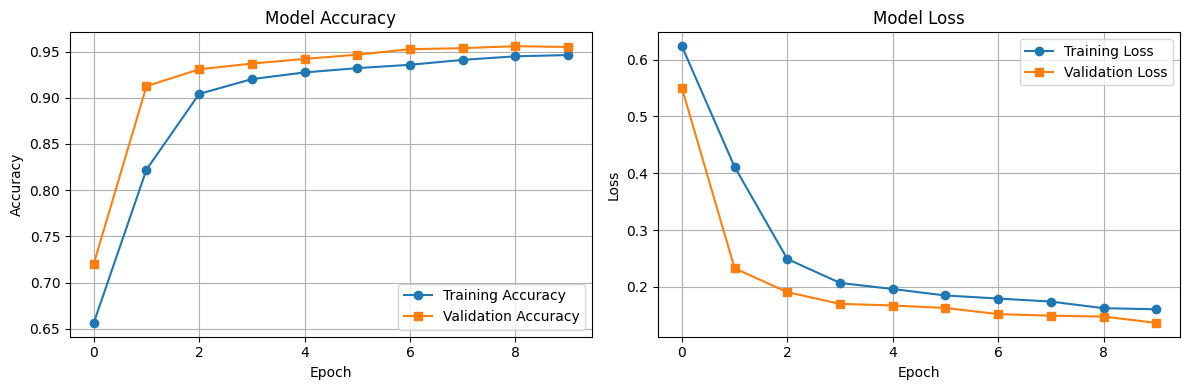

In [ ]:
import matplotlib.pyplot as plt
def plot_training_history(history):
    """Plot training and validation accuracy and loss"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss', marker='o')
    ax2.plot(history.history['val_loss'], label='Validation Loss', marker='s')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)

**save model and prediction function to test other new images just incase**

In [ ]:
# Save the model
model.save('simple_malaria_cnn_model.keras')
print("Model saved as 'simple_malaria_cnn_model.h5'")

# Function to make predictions on new images
def predict_image(model, image_path):
    """Make prediction on a single image"""
    from tensorflow.keras.preprocessing import image

    img = image.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    prediction = model.predict(img_array)
    class_names = ['Infected', 'Uninfected']
    predicted_class = class_names[np.argmax(prediction)]
    confidence = np.max(prediction)

    return predicted_class, confidence

print("Prediction function created!")
print("\n=== SIMPLE CNN BENCHMARK MODEL COMPLETED ===")

Model saved as 'simple_malaria_cnn_model.h5'
Prediction function created!

=== SIMPLE CNN BENCHMARK MODEL COMPLETED ===


**testing with images in my test dataset**

Ready to test 100 images!
y = 0, it's a 'Infected' cell.
Predicted = 0, model says 'Infected' with 0.978 confidence.


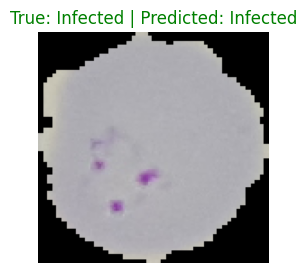

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

infected_test_dir = os.path.join(testing_path, 'Infected')
uninfected_test_dir = os.path.join(testing_path, 'Uninfected')

infected_files = [f for f in os.listdir(infected_test_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
uninfected_files = [f for f in os.listdir(uninfected_test_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Create simple arrays
test_image_paths = []
test_labels = []

# Add infected images (label = 0)
for f in infected_files[:50]:
    test_image_paths.append(os.path.join(infected_test_dir, f))
    test_labels.append(0)

# Add uninfected images (label = 1)
for f in uninfected_files[:50]:
    test_image_paths.append(os.path.join(uninfected_test_dir, f))
    test_labels.append(1)

classes = ['Infected', 'Uninfected']
print(f"Ready to test {len(test_image_paths)} images!")
# Simple testing function
def test_malaria_image(index):
    img_path = test_image_paths[index]
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    prediction = model.predict(img_array, verbose=0)
    predicted_class = np.argmax(prediction)
    confidence = np.max(prediction)
    fig = plt.figure(figsize=(3, 3))
    plt.imshow(img)
    plt.axis('off')


    true_label = test_labels[index]
    color = 'green' if true_label == predicted_class else 'red'
    plt.title(f"True: {classes[true_label]} | Predicted: {classes[predicted_class]}", color=color)

    print("y = " + str(true_label) + ", it's a '" + classes[true_label] + "' cell.")
    print("Predicted = " + str(predicted_class) + ", model says '" + classes[predicted_class] + "' with " + str(round(confidence, 3)) + " confidence.")

    plt.show()

# Example usage (change index to test different images)
index = 3
test_malaria_image(index)

# Sage Muhodari. (Transfer learning using VGG16
)
Transfer learning using VGG16



Libaries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import pandas as pd


Configuration

In [ ]:
IMG_HEIGHT, IMG_WIDTH = 128, 128
BATCH_SIZE = 32
EPOCHS = 15

print(f"Training samples: {train_generator.samples}")
print(f"Testing samples:  {test_generator.samples}")
print("Configuration set for VGG16 experiments!")


Training samples: 22046
Testing samples:  5512
Configuration set for VGG16 experiments!


Evaluation helper functions

In [ ]:
def get_predictions_and_labels(model, generator):
    """Get model probabilities, predicted classes and true labels from a generator"""
    generator.reset()
    predictions = model.predict(generator, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = generator.classes
    return predictions, predicted_classes, true_classes

def calculate_metrics(true_labels, predicted_labels):
    """Calculate common classification metrics (weighted)"""
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=0)
    recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=0)
    f1 = f1_score(true_labels, predicted_labels, average='weighted', zero_division=0)
    return {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-Score': f1}

print("Evaluation functions defined!")


Evaluation functions defined!


Visualization functions

In [ ]:
def plot_learning_curves(history, experiment_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
    ax1.plot(history.history.get('accuracy', []), label='Training Accuracy', marker='o')
    ax1.plot(history.history.get('val_accuracy', []), label='Validation Accuracy', marker='s')
    ax1.set_title(f'{experiment_name}\nModel Accuracy', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Epoch'); ax1.set_ylabel('Accuracy'); ax1.legend(); ax1.grid(True, alpha=0.3)

    ax2.plot(history.history.get('loss', []), label='Training Loss', marker='o')
    ax2.plot(history.history.get('val_loss', []), label='Validation Loss', marker='s')
    ax2.set_title(f'{experiment_name}\nModel Loss', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Epoch'); ax2.set_ylabel('Loss'); ax2.legend(); ax2.grid(True, alpha=0.3)

    plt.tight_layout(); plt.show()

def plot_confusion_matrix(true_labels, predicted_labels, experiment_name, class_names=None):
    cm = confusion_matrix(true_labels, predicted_labels)
    if class_names is None:
        class_names = ['Class 0', 'Class 1'] if cm.shape[0]==2 else [f'Class {i}' for i in range(cm.shape[0])]
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{experiment_name}\nConfusion Matrix', fontsize=12, fontweight='bold'); plt.ylabel('True Label'); plt.xlabel('Predicted Label')
    plt.tight_layout(); plt.show()
    return cm

def plot_roc_curve(true_labels, predictions, experiment_name):
    if predictions.shape[1] == 2:
        fpr, tpr, _ = roc_curve(true_labels, predictions[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(8,6))
        plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
        plt.plot([0,1],[0,1], lw=2, linestyle='--', label='Random Classifier')
        plt.xlim([0.0,1.0]); plt.ylim([0.0,1.05]); plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
        plt.title(f'{experiment_name}\nROC Curve', fontsize=12, fontweight='bold'); plt.legend(loc='lower right'); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()
        return roc_auc
    else:
        print("ROC plotting for multiclass not implemented in this helper.")
        return None

print("Visualization functions defined!")


Visualization functions defined!


Full evaluation wrapper

In [ ]:
def evaluate_model(model, generator, experiment_name, class_names=None):
    print("\n" + "="*60)
    print(f"EVALUATING: {experiment_name}")
    print("="*60 + "\n")

    predictions, predicted_classes, true_classes = get_predictions_and_labels(model, generator)
    metrics = calculate_metrics(true_classes, predicted_classes)

    print("Performance Metrics:")
    print("-" * 40)
    for metric, value in metrics.items():
        print(f"{metric:15s}: {value:.4f} ({value*100:.2f}%)")

    print("\nGenerating visualizations...")
    cm = plot_confusion_matrix(true_classes, predicted_classes, experiment_name, class_names)
    roc_auc = plot_roc_curve(true_classes, predictions, experiment_name)
    metrics['AUC'] = roc_auc

    print("\nDetailed Classification Report:")
    print("-" * 40)
    if class_names is None:
        class_names = ['Class 0', 'Class 1'] if len(np.unique(true_classes))==2 else [f'Class {i}' for i in sorted(np.unique(true_classes))]
    print(classification_report(true_classes, predicted_classes, target_names=class_names, zero_division=0))
    return metrics

print("Complete evaluation function ready!")


Complete evaluation function ready!


EXPERIMENT 1: Feature Extraction - Baseline (Freeze VGG16)


EXPERIMENT 1: Feature Extraction - Baseline
Strategy: Freeze all VGG16 layers, train top Dense layers
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,610 (56.38 MB)

 Trainable params: 65,922 (257.51 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 149s 204ms/step - accuracy: 0.8333 - loss: 0.3870 - val_accuracy: 0.9209 - val_loss: 0.2029 - learning_rate: 0.0010
Epoch 2/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 132s 192ms/step - accuracy: 0.9183 - loss: 0.2133 - val_accuracy: 0.9318 - val_loss: 0.1855 - learning_rate: 0.0010
Epoch 3/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 131s 190ms/step - accuracy: 0.9240 - loss: 0.2074 - val_accuracy: 0.9340 - val_loss: 0.1763 - learning_rate: 0.0010
Epoch 4/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 131s 190ms/step - accuracy: 0.9259 - loss: 0.2006 - val_accuracy: 0.9352 - val_loss: 0.1693 - learning_rate: 0.0010
Epoch 5/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 131s 191ms/step - accuracy: 0.9288 - loss: 0.1917 - val_accuracy: 0.9349 - val_loss: 0.1650 - learning_rate: 0.0010
Epoch 6/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 131s 190ms/step - accuracy: 0.9332 - loss: 0.1839 - val_accuracy: 0.9321 - val_loss: 0.1777 - learning_rate: 0.0010
Epoch 7/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 130s 188ms/step - accura

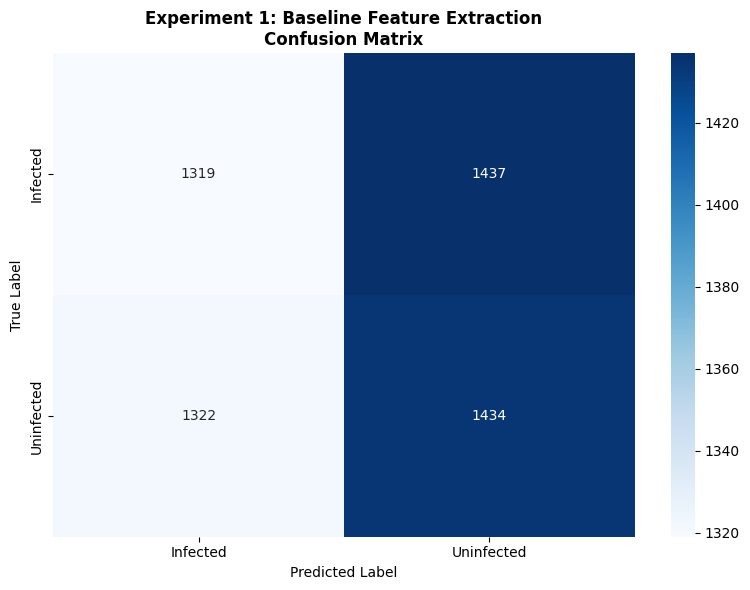

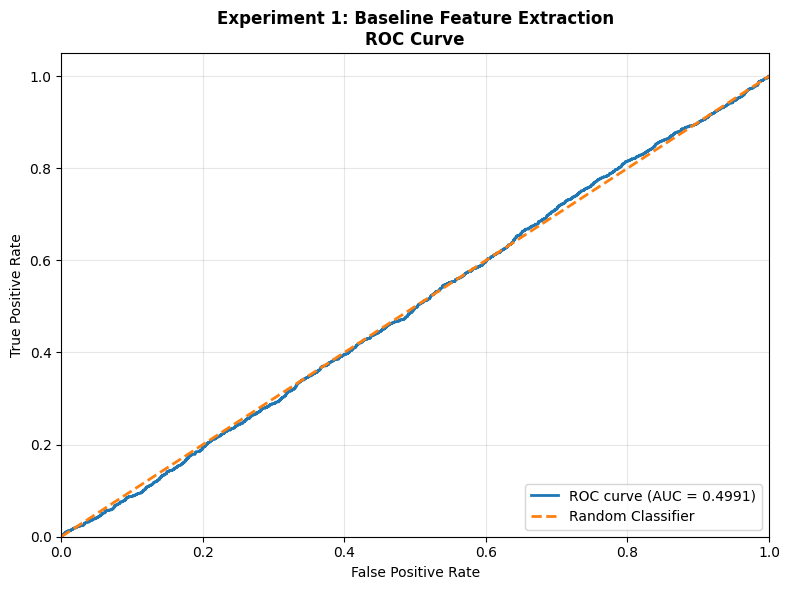


Detailed Classification Report:
----------------------------------------
              precision    recall  f1-score   support

    Infected       0.50      0.48      0.49      2756
  Uninfected       0.50      0.52      0.51      2756

    accuracy                           0.50      5512
   macro avg       0.50      0.50      0.50      5512
weighted avg       0.50      0.50      0.50      5512



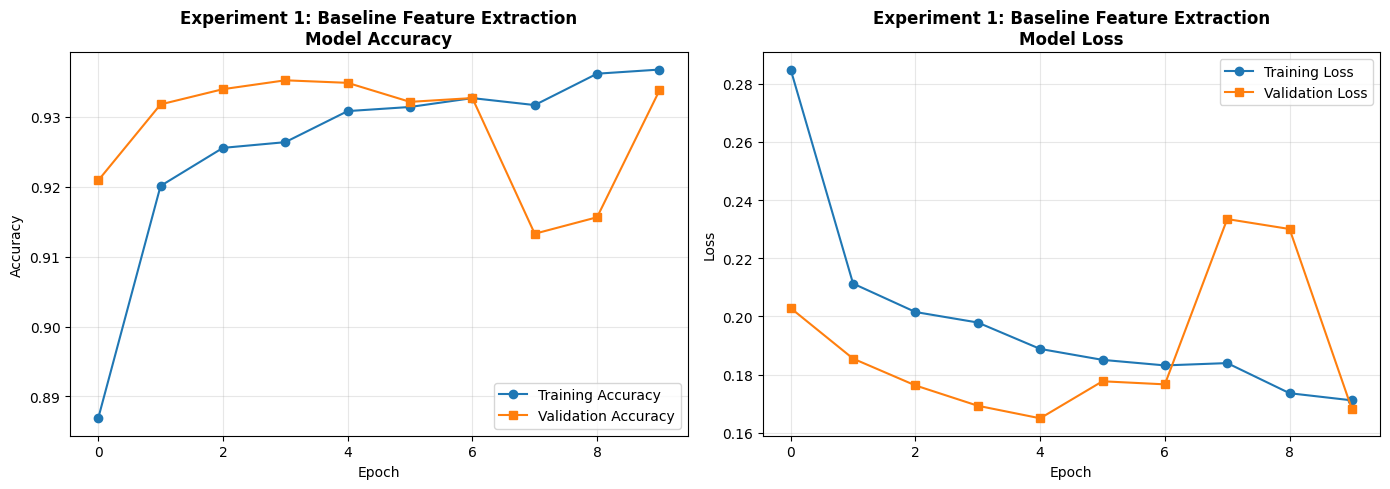

Experiment 1 completed and saved.


In [ ]:
print("\n" + "="*60)
print("EXPERIMENT 1: Feature Extraction - Baseline")
print("="*60)
print("Strategy: Freeze all VGG16 layers, train top Dense layers")

base_model_exp1 = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model_exp1.trainable = False

x = base_model_exp1.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

model_exp1 = Model(inputs=base_model_exp1.input, outputs=output)
model_exp1.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
model_exp1.summary()

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]

history_exp1 = model_exp1.fit(train_generator, epochs=EPOCHS, validation_data=test_generator, callbacks=callbacks, verbose=1)
metrics_exp1 = evaluate_model(model_exp1, test_generator, "Experiment 1: Baseline Feature Extraction", class_names=list(train_generator.class_indices.keys()))
plot_learning_curves(history_exp1, "Experiment 1: Baseline Feature Extraction")
model_exp1.save('vgg16_exp1_baseline.keras')
print("Experiment 1 completed and saved.")


EXPERIMENT 2: Feature Extraction + Dropout


EXPERIMENT 2: Feature Extraction with Dropout
Strategy: Freeze VGG16, add Dropout to reduce overfitting


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,610 (56.38 MB)

 Trainable params: 65,922 (257.51 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 135s 190ms/step - accuracy: 0.8114 - loss: 0.4141 - val_accuracy: 0.9267 - val_loss: 0.2003 - learning_rate: 0.0010
Epoch 2/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 130s 188ms/step - accuracy: 0.9093 - loss: 0.2417 - val_accuracy: 0.9298 - val_loss: 0.1838 - learning_rate: 0.0010
Epoch 3/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 129s 188ms/step - accuracy: 0.9141 - loss: 0.2295 - val_accuracy: 0.9229 - val_loss: 0.1937 - learning_rate: 0.0010
Epoch 4/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 129s 187ms/step - accuracy: 0.9201 - loss: 0.2216 - val_accuracy: 0.8908 - val_loss: 0.2592 - learning_rate: 0.0010
Epoch 5/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 128s 185ms/step - accuracy: 0.9182 - loss: 0.2112 - val_accuracy: 0.9169 - val_loss: 0.1985 - learning_rate: 0.0010
Epoch 6/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 128s 186ms/step - accuracy: 0.9237 - loss: 0.2071 - val_accuracy: 0.9303 - val_loss: 0.1810 - learning_rate: 5.0000e-04
Epoch 7/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 131s 191ms/step - ac

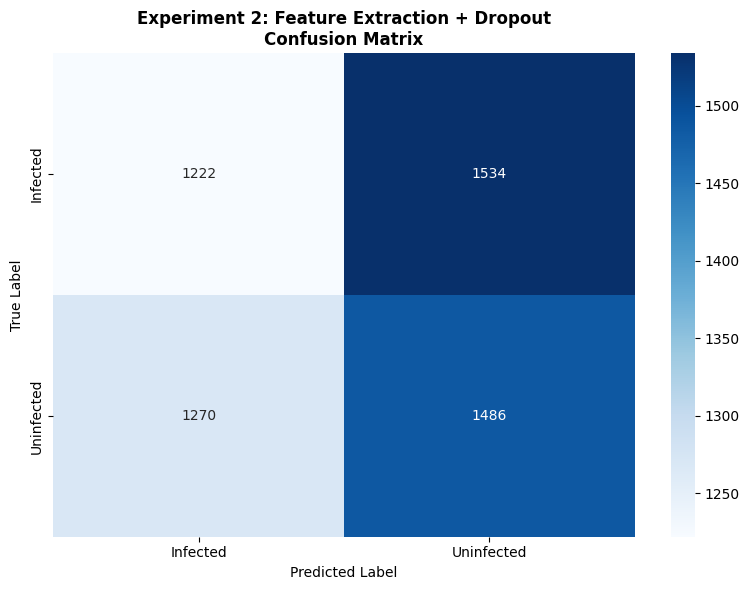

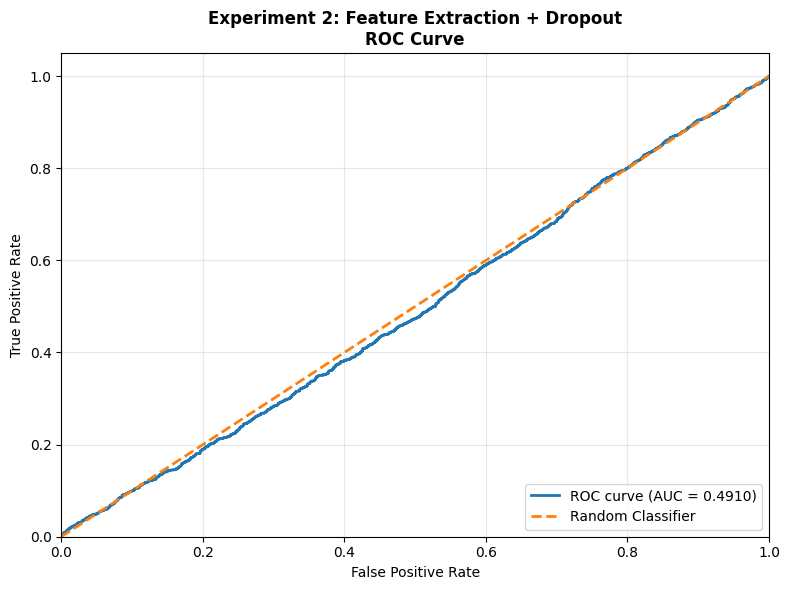


Detailed Classification Report:
----------------------------------------
              precision    recall  f1-score   support

    Infected       0.49      0.44      0.47      2756
  Uninfected       0.49      0.54      0.51      2756

    accuracy                           0.49      5512
   macro avg       0.49      0.49      0.49      5512
weighted avg       0.49      0.49      0.49      5512



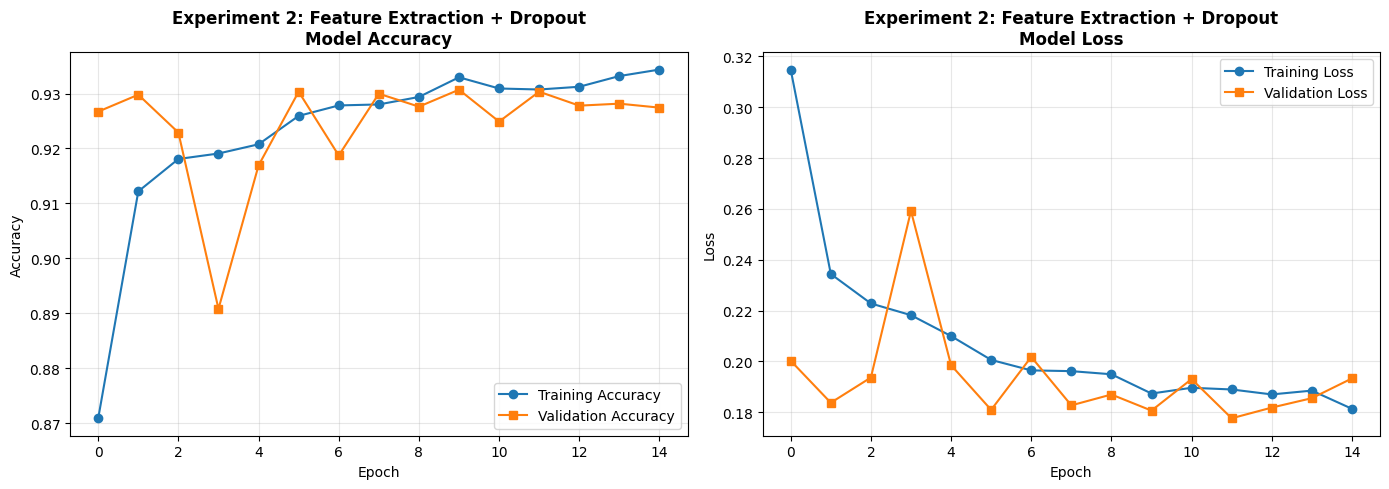

Experiment 2 completed and saved.


In [ ]:
print("\n" + "="*60)
print("EXPERIMENT 2: Feature Extraction with Dropout")
print("="*60)
print("Strategy: Freeze VGG16, add Dropout to reduce overfitting")

base_model_exp2 = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model_exp2.trainable = False

x = base_model_exp2.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(2, activation='softmax')(x)

model_exp2 = Model(inputs=base_model_exp2.input, outputs=output)
model_exp2.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
model_exp2.summary()

history_exp2 = model_exp2.fit(train_generator, epochs=EPOCHS, validation_data=test_generator, callbacks=callbacks, verbose=1)
metrics_exp2 = evaluate_model(model_exp2, test_generator, "Experiment 2: Feature Extraction + Dropout", class_names=list(train_generator.class_indices.keys()))
plot_learning_curves(history_exp2, "Experiment 2: Feature Extraction + Dropout")
model_exp2.save('vgg16_exp2_dropout.keras')
print("Experiment 2 completed and saved.")


EXPERIMENT 3: Fine-Tuning (unfreeze last conv block)


EXPERIMENT 3: Fine-tuning - Unfreeze last VGG16 conv block
Strategy: Start from pretrained weights, unfreeze last convolutional block and fine-tune with a lower LR


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,530 (56.64 MB)

 Trainable params: 7,211,266 (27.51 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

Epoch 1/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 145s 204ms/step - accuracy: 0.8997 - loss: 0.2458 - val_accuracy: 0.9541 - val_loss: 0.1314 - learning_rate: 1.0000e-04
Epoch 2/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 132s 191ms/step - accuracy: 0.9519 - loss: 0.1479 - val_accuracy: 0.9572 - val_loss: 0.1175 - learning_rate: 1.0000e-04
Epoch 3/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 133s 192ms/step - accuracy: 0.9564 - loss: 0.1318 - val_accuracy: 0.9639 - val_loss: 0.1043 - learning_rate: 1.0000e-04
Epoch 4/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 131s 190ms/step - accuracy: 0.9584 - loss: 0.1232 - val_accuracy: 0.9644 - val_loss: 0.1030 - learning_rate: 1.0000e-04
Epoch 5/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 131s 189ms/step - accuracy: 0.9589 - loss: 0.1203 - val_accuracy: 0.9652 - val_loss: 0.1030 - learning_rate: 1.0000e-04
Epoch 6/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 135s 197ms/step - accuracy: 0.9622 - loss: 0.1114 - val_accuracy: 0.9648 - val_loss: 0.1022 - learning_rate: 1.0000e-04
Epoch 7/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 

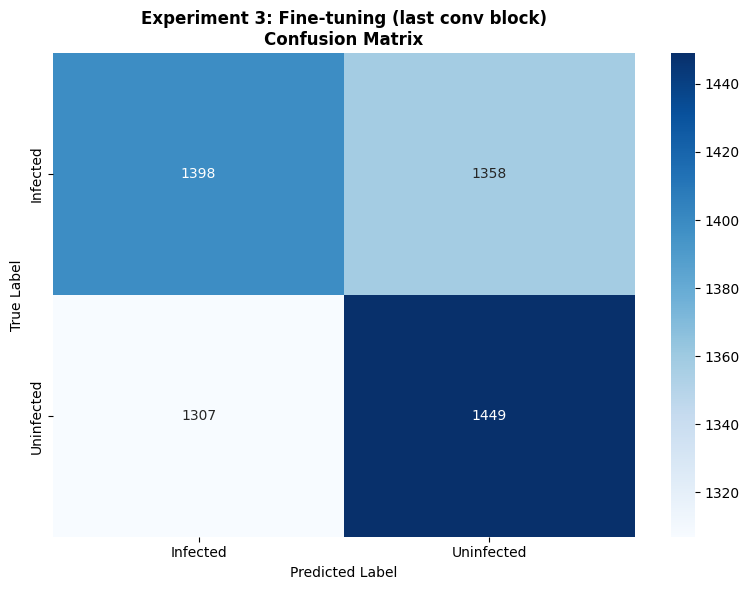

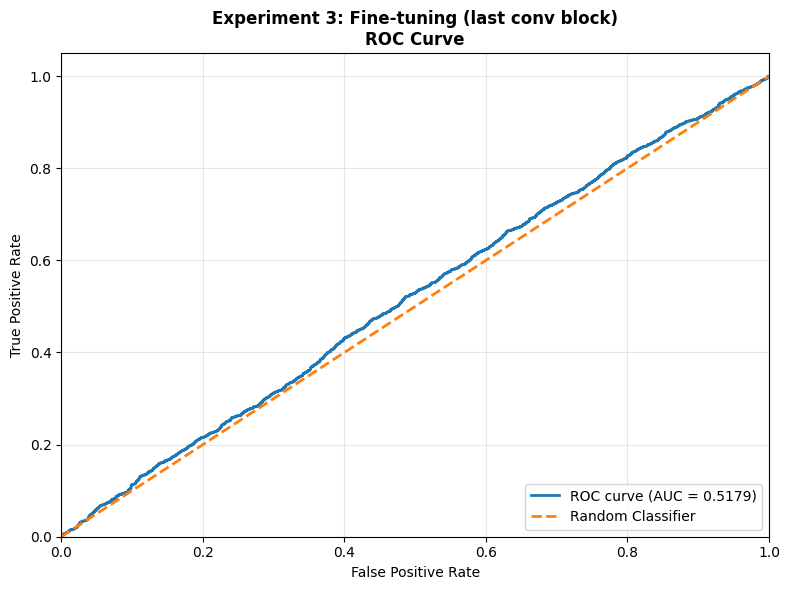


Detailed Classification Report:
----------------------------------------
              precision    recall  f1-score   support

    Infected       0.52      0.51      0.51      2756
  Uninfected       0.52      0.53      0.52      2756

    accuracy                           0.52      5512
   macro avg       0.52      0.52      0.52      5512
weighted avg       0.52      0.52      0.52      5512



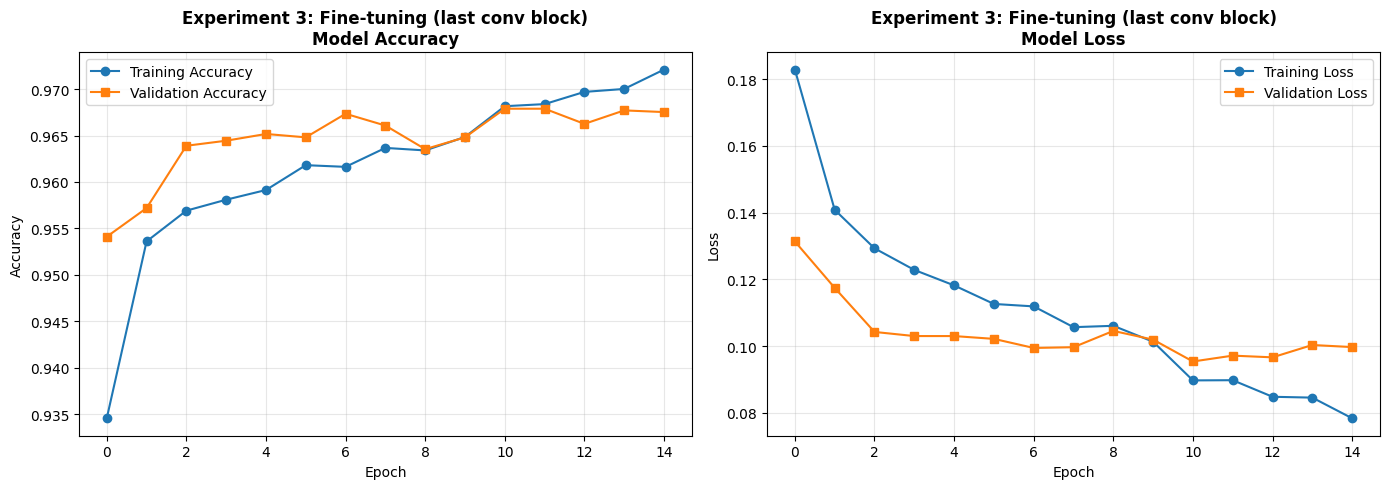

Experiment 3 completed and saved.


In [ ]:
print("\n" + "="*80)
print("EXPERIMENT 3: Fine-tuning - Unfreeze last VGG16 conv block")
print("="*80)
print("Strategy: Start from pretrained weights, unfreeze last convolutional block and fine-tune with a lower LR")

base_model_exp3 = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

for layer in base_model_exp3.layers:
    layer.trainable = False

unfreeze_from = 'block5_conv1'
set_trainable = False
for layer in base_model_exp3.layers:
    if layer.name == unfreeze_from:
        set_trainable = True
    if set_trainable:
        layer.trainable = True

x = base_model_exp3.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(2, activation='softmax')(x)

model_exp3 = Model(inputs=base_model_exp3.input, outputs=output)

model_exp3.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model_exp3.summary()

callbacks_ft = callbacks + [ModelCheckpoint('vgg16_exp3_best.keras', monitor='val_loss', save_best_only=True)]

history_exp3 = model_exp3.fit(train_generator, epochs=EPOCHS, validation_data=test_generator, callbacks=callbacks_ft, verbose=1)
try:
    model_exp3.load_weights('vgg16_exp3_best.keras')
except Exception:
    pass

metrics_exp3 = evaluate_model(model_exp3, test_generator, "Experiment 3: Fine-tuning (last conv block)", class_names=list(train_generator.class_indices.keys()))
plot_learning_curves(history_exp3, "Experiment 3: Fine-tuning (last conv block)")
model_exp3.save('vgg16_exp3_finetuned.keras')
print("Experiment 3 completed and saved.")


Comparative summary & plotting


COMPARATIVE RESULTS - ALL EXPERIMENTS

Performance Metrics Table:
--------------------------------------------------------------------------------
                 Experiment  Accuracy  Precision   Recall  F1-Score      AUC
Exp 1: Baseline (128 Dense)  0.499456   0.499455 0.499456  0.499238 0.499103
     Exp 2: + Dropout (0.5)  0.491292   0.491211 0.491292  0.490122 0.491002
 Exp 3: Fine-tuned (block5)  0.516509   0.516515 0.516509  0.516468 0.517913


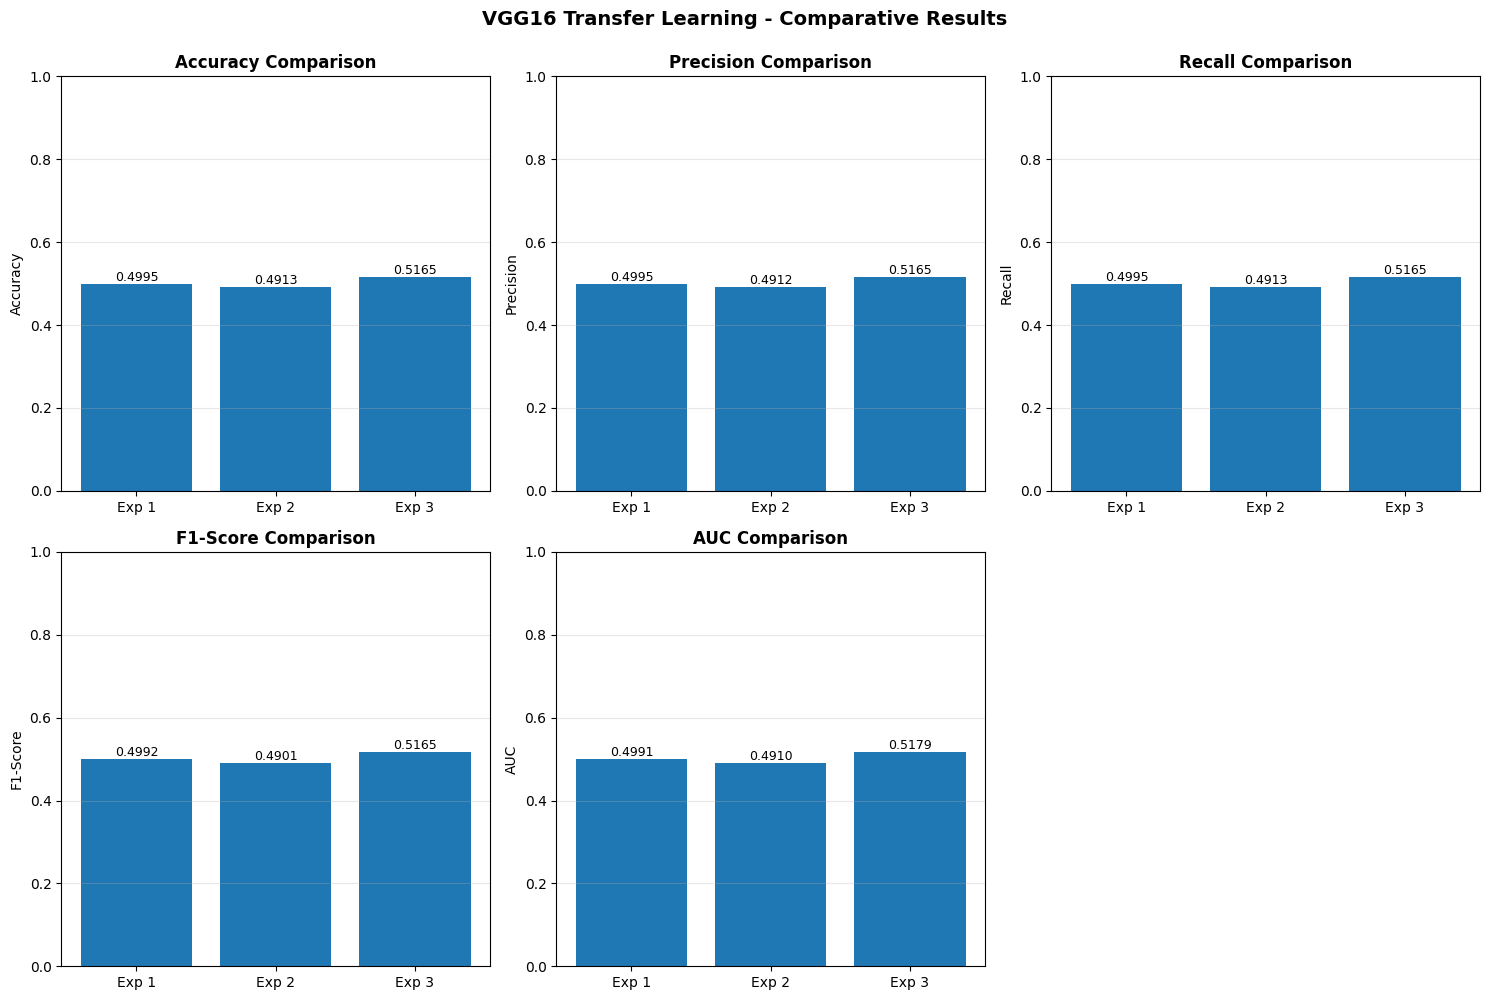

Results saved to 'vgg16_experiments_results.csv'
All experiments completed.


In [ ]:
print("\n" + "="*80)
print("COMPARATIVE RESULTS - ALL EXPERIMENTS")
print("="*80)

results_df = pd.DataFrame({
    'Experiment': [
        'Exp 1: Baseline (128 Dense)',
        'Exp 2: + Dropout (0.5)',
        'Exp 3: Fine-tuned (block5)'
    ],
    'Accuracy': [metrics_exp1['Accuracy'], metrics_exp2['Accuracy'], metrics_exp3['Accuracy']],
    'Precision': [metrics_exp1['Precision'], metrics_exp2['Precision'], metrics_exp3['Precision']],
    'Recall': [metrics_exp1['Recall'], metrics_exp2['Recall'], metrics_exp3['Recall']],
    'F1-Score': [metrics_exp1['F1-Score'], metrics_exp2['F1-Score'], metrics_exp3['F1-Score']],
    'AUC': [metrics_exp1.get('AUC'), metrics_exp2.get('AUC'), metrics_exp3.get('AUC')]
})

print("\nPerformance Metrics Table:")
print("-" * 80)
print(results_df.to_string(index=False))

# Bar plots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
metrics_list = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
experiments = results_df['Experiment'].tolist()

for idx, metric in enumerate(metrics_list):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    values = results_df[metric].tolist()
    bars = ax.bar(range(len(experiments)), values)
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} Comparison', fontweight='bold')
    ax.set_xticks(range(len(experiments)))
    ax.set_xticklabels(['Exp 1', 'Exp 2', 'Exp 3'])
    ax.set_ylim([0.0, 1.0])
    ax.grid(True, alpha=0.3, axis='y')
    for i, (bar, val) in enumerate(zip(bars, values)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height, f'{val:.4f}', ha='center', va='bottom', fontsize=9)

# Remove empty subplot if any
axes[1,2].axis('off')
plt.suptitle('VGG16 Transfer Learning - Comparative Results', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout(); plt.show()

results_df.to_csv('vgg16_experiments_results.csv', index=False)
print("Results saved to 'vgg16_experiments_results.csv'")
print("All experiments completed.")
